# Noise reduction in analog tape audio recordings with deep learning models

This notebook is a demo of the analog tape noise reduction model proposed in:

>I. Irigaray, M. Rocamora and L. W. P. Biscainho, "Noise reduction in analog tape audio recordings with deep learning models", submittet to AES 2023 International Conference on Audio Archiving, Preservation & Restoration, USA, Jun, 2023.


### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell
* For some reason, this notebook does not work in Firefox, so please use another browser.


Notebook based on the work of Eloi Moliner:

> E. Moliner and V. Välimäki,, "A two-stage U-Net for high-fidelity denosing of historical recordings", submitted to IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP), Singapore, May, 2022

### How to run the notebook

You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/mir_workshop/blob/main/notebooks/MIR_workshop_audio_synchronization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
#@title #Install and Import

#@markdown Execute this cell to install the required data and dependencies. This step might take some time.

#download the files
! git clone https://github.com/eloimoliner/denoising-historical-recordings.git
! wget https://github.com/IgnacioIrigaray/AnalgAudioTapeDenoising/releases/download/v0.1.0-beta/tape_network_1.1.zip
! unzip tape_network_1.1.zip -d denoising-historical-recordings/experiments/trained_model/

%cd denoising-historical-recordings

#install dependencies
! pip install hydra-core==0.11.3
! pip install librosa
! pip install libfmp
#All the code goes here
import unet
import tensorflow as tf
import soundfile as sf
import numpy as np
from tqdm import tqdm
import scipy.signal
import hydra
import os
#workaround to load hydra conf file
import yaml
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from libfmp.b.b_plot import plot_signal, plot_chromagram
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points
from pathlib import Path
args = yaml.safe_load(Path('conf/conf.yaml').read_text())
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args=dotdict(args)
unet_args=dotdict(args.unet)

path_experiment=str(args.path_experiment)

unet_model = unet.build_model_denoise(unet_args=unet_args)

ckpt=os.path.join("/content/denoising-historical-recordings",path_experiment, 'checkpoint')
unet_model.load_weights(ckpt)

def do_stft(noisy):

    window_fn = tf.signal.hamming_window

    win_size=args.stft["win_size"]
    hop_size=args.stft["hop_size"]

    
    stft_signal_noisy=tf.signal.stft(noisy,frame_length=win_size, window_fn=window_fn, frame_step=hop_size, pad_end=True)
    stft_noisy_stacked=tf.stack( values=[tf.math.real(stft_signal_noisy), tf.math.imag(stft_signal_noisy)], axis=-1)

    return stft_noisy_stacked

def do_istft(data):
    
    window_fn = tf.signal.hamming_window
    win_size=args.stft["win_size"]
    hop_size=args.stft["hop_size"]
    inv_window_fn=tf.signal.inverse_stft_window_fn(hop_size, forward_window_fn=window_fn)
    pred_cpx=data[...,0] + 1j * data[...,1]
    pred_time=tf.signal.inverse_stft(pred_cpx, win_size, hop_size, window_fn=inv_window_fn)
    return pred_time

def denoise_audio(audio):
    data, samplerate = sf.read(audio)
    print(data.dtype)
    #Stereo to mono
    if len(data.shape)>1:
        data=np.mean(data,axis=1)
    
    if samplerate!=44100: 
        print("Resampling")
   
        data=scipy.signal.resample(data, int((44100  / samplerate )*len(data))+1)      
    segment_size=44100*5  #20s segments
    length_data=len(data)
    overlapsize=2048 #samples (46 ms)
    window=np.hanning(2*overlapsize)
    window_right=window[overlapsize::]
    window_left=window[0:overlapsize]
    audio_finished=False
    pointer=0
    denoised_data=np.zeros(shape=(len(data),))
    residual_noise=np.zeros(shape=(len(data),))
    numchunks=int(np.ceil(length_data/segment_size))
     
    for i in tqdm(range(numchunks)):
        if pointer+segment_size<length_data:
            segment=data[pointer:pointer+segment_size]
            #dostft
            segment_TF=do_stft(segment)
            segment_TF_ds=tf.data.Dataset.from_tensors(segment_TF)
            pred = unet_model.predict(segment_TF_ds.batch(1))
            pred=pred[0]
            residual=segment_TF-pred[0]
            residual=np.array(residual)
            pred_time=do_istft(pred[0])
            residual_time=do_istft(residual)
            residual_time=np.array(residual_time)

            if pointer==0:
                pred_time=np.concatenate((pred_time[0:int(segment_size-overlapsize)], np.multiply(pred_time[int(segment_size-overlapsize):segment_size],window_right)), axis=0)
                residual_time=np.concatenate((residual_time[0:int(segment_size-overlapsize)], np.multiply(residual_time[int(segment_size-overlapsize):segment_size],window_right)), axis=0)
            else:
                pred_time=np.concatenate((np.multiply(pred_time[0:int(overlapsize)], window_left), pred_time[int(overlapsize):int(segment_size-overlapsize)], np.multiply(pred_time[int(segment_size-overlapsize):int(segment_size)],window_right)), axis=0)
                residual_time=np.concatenate((np.multiply(residual_time[0:int(overlapsize)], window_left), residual_time[int(overlapsize):int(segment_size-overlapsize)], np.multiply(residual_time[int(segment_size-overlapsize):int(segment_size)],window_right)), axis=0)
                
            denoised_data[pointer:pointer+segment_size]=denoised_data[pointer:pointer+segment_size]+pred_time
            residual_noise[pointer:pointer+segment_size]=residual_noise[pointer:pointer+segment_size]+residual_time

            pointer=pointer+segment_size-overlapsize
        else: 
            segment=data[pointer::]
            lensegment=len(segment)
            segment=np.concatenate((segment, np.zeros(shape=(int(segment_size-len(segment)),))), axis=0)
            audio_finished=True
            #dostft
            segment_TF=do_stft(segment)

            segment_TF_ds=tf.data.Dataset.from_tensors(segment_TF)

            pred = unet_model.predict(segment_TF_ds.batch(1))
            pred=pred[0]
            residual=segment_TF-pred[0]
            residual=np.array(residual)
            pred_time=do_istft(pred[0])
            pred_time=np.array(pred_time)
            pred_time=pred_time[0:segment_size]
            residual_time=do_istft(residual)
            residual_time=np.array(residual_time)
            residual_time=residual_time[0:segment_size]
            if pointer==0:
                pred_time=pred_time
                residual_time=residual_time
            else:
                pred_time=np.concatenate((np.multiply(pred_time[0:int(overlapsize)], window_left), pred_time[int(overlapsize):int(segment_size)]),axis=0)
                residual_time=np.concatenate((np.multiply(residual_time[0:int(overlapsize)], window_left), residual_time[int(overlapsize):int(segment_size)]),axis=0)

            denoised_data[pointer::]=denoised_data[pointer::]+pred_time[0:lensegment]
            residual_noise[pointer::]=residual_noise[pointer::]+residual_time[0:lensegment]
    return denoised_data

Cloning into 'denoising-historical-recordings'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 226 (delta 14), reused 7 (delta 7), pack-reused 206
Receiving objects: 100% (226/226), 116.50 KiB | 2.38 MiB/s, done.
Resolving deltas: 100% (88/88), done.
--2023-03-21 18:09:55--  https://github.com/IgnacioIrigaray/AnalgAudioTapeDenoising/releases/download/v0.1.0-beta/tape_network_1.1.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IgnacioIrigaray/AnalogAudioTapeDenoising/releases/download/v0.1.0-beta/tape_network_1.1.zip [following]
--2023-03-21 18:09:55--  https://github.com/IgnacioIrigaray/AnalogAudioTapeDenoising/releases/download/v0.1.0-beta/tape_network_1.1.zip
Reusing existing connection to github.com:443.
HTTP request

In [14]:
#@title #Download audio files to work with.



! wget https://archive.org/download/noisy_16_202303/noisy_16.wav -O audio.wav

--2023-03-21 18:41:48--  https://archive.org/download/noisy_16_202303/noisy_16.wav
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia902608.us.archive.org/25/items/noisy_16_202303/noisy_16.wav [following]
--2023-03-21 18:41:48--  https://ia902608.us.archive.org/25/items/noisy_16_202303/noisy_16.wav
Resolving ia902608.us.archive.org (ia902608.us.archive.org)... 207.241.228.238
Connecting to ia902608.us.archive.org (ia902608.us.archive.org)|207.241.228.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2646044 (2.5M) [audio/x-wav]
Saving to: ‘audio.wav’

audio.wav           100%[===================>]   2.52M  9.77MB/s    in 0.3s    

2023-03-21 18:41:49 (9.77 MB/s) - ‘audio.wav’ saved [2646044/2646044]



In [15]:
#@title #Denoise

#@markdown Execute this cell to denoise the uploaded file
#for fn in uploaded.keys():
# print('Denoising uploaded file "{name}"'.format(
#      name=fn))
denoise_data=denoise_audio('audio.wav')
basename='audio'
wav_output_name=basename+"_denoised"+".wav"
sf.write(wav_output_name, denoise_data, 44100)

float64


  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step


 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2/6 [00:01<00:02,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4/6 [00:01<00:00,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 5/6 [00:02<00:00,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 6/6 [00:02<00:00,  2.00it/s]


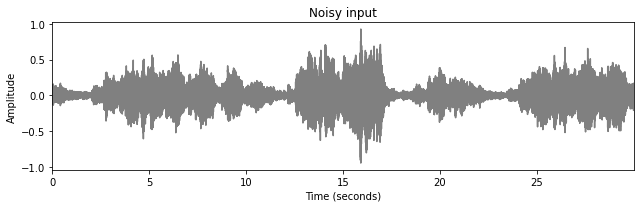

In [19]:
figsize = (9, 3)
fn_wav1 = os.path.join('audio.wav')

audio_1, Fs = librosa.load(fn_wav1)

plot_signal(audio_1, Fs=Fs, ylabel='Amplitude', title='Noisy input', figsize=figsize)
ipd.display(ipd.Audio(audio_1, rate=Fs))

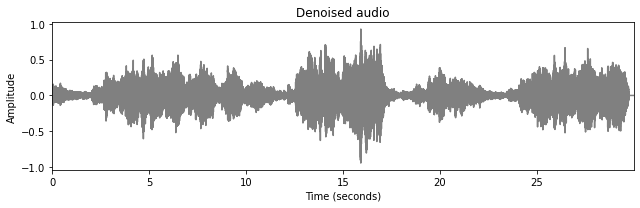

In [20]:
fn_wav2 = os.path.join('audio_denoised.wav')

audio_2, Fs = librosa.load(fn_wav2)

plot_signal(audio_2, Fs=Fs, ylabel='Amplitude', title='Denoised audio', figsize=figsize)
ipd.display(ipd.Audio(audio_2, rate=Fs))